# Model Development of *Lending Club* Loan Predictor

## 1. Preparation

First we will load previously created transformer and dataset!

In [33]:
import pandas as pd
import numpy as np
import os
import sys
from joblib import load


# general pandas setting
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)

# set parent dir.
parent_dir = os.path.dirname(sys.path[0])
sys.path.append(parent_dir + '\Modules')

# importing train and test set
X_train_res = pd.read_csv(parent_dir + '\Output\X_train_res.csv')
y_train_res = pd.read_csv(parent_dir + '\Output\y_train_res.csv').iloc[:, 0]
X_test = pd.read_csv(parent_dir + '\Output\X_test.csv')
y_test = pd.read_csv(parent_dir + '\Output\y_test.csv').iloc[:, 0]

In [34]:
from custom_transformer import AttributesDropper

# importing fitted data preprocessing transformer
preprocessing_transf = load(parent_dir + '\Models\preprocessing_transf.joblib')
preprocessing_transf

Pipeline(steps=[('attributesdropper', AttributesDropper()),
                ('columntransformer-1',
                 ColumnTransformer(transformers=[('grade_enc',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['grade']),
                                                 ('sub_grade_enc',
                                                  OrdinalEncoder(categories=[['A1',
                                                                              'A2',
                                                                              'A3',
                                                                              'A4',
                                                                              'A5',
                                                                              'B1',
                                                                              'B2',
                                                                              'B3',
                                                                              'B4',
                                                                              'B5',
                                                                              'C1',
                                                                              '...
                                                   'tot_cur_bal',
                                                   'total_rev_hi_lim'])])),
                ('columntransformer-2',
                 ColumnTransformer(transformers=[('categorical_imp',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]),
                                                 ('numerical_imp',
                                                  IterativeImputer(max_iter=3,
                                                                   n_nearest_features=15,
                                                                   random_state=99,
                                                                   sample_posterior=True),
                                                  [14, 15, 16, 17, 18, 19, 20,
                                                   21, 22, 23, 24, 25, 26, 27,
                                                   28, 29, 30])]))])

Preparing train-test set.

In [35]:
X_train_res_transf = preprocessing_transf.fit_transform(X_train_res)
X_test_transf = preprocessing_transf.transform(X_test)

## 2. Selecting Baseline Model

Now we are going to select several potentially baseline model for our classification task!
For each potential model, we are going to observe how the model performs by comparing the model performance. And also, we will perform *Feature Selection* using `Recursive Feature Elimination (RFE)`, focusing on `accuracy` score of `Charged Off` class. 

### 2.1. Stochastic Gradient Descent Classifier (SGDClassifier)

In [36]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=99)


#### **Feature Selection**

Optimal number of features: 29


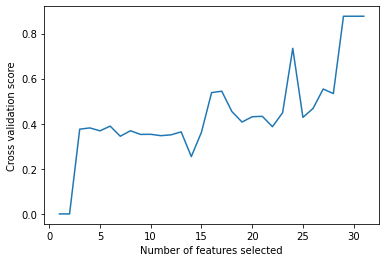

In [37]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

features_evaluator = RFECV(estimator=sgd_clf, cv=StratifiedKFold(2), scoring='recall')
features_evaluator.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
rfecv_mean = features_evaluator.cv_results_['mean_test_score']
optimal_n_features = features_evaluator.n_features_

# plotting
def plot_feature_evaluator(rfecv_mean, optimal_n_features):
    plt.plot(
        range(1, len(rfecv_mean) + 1), rfecv_mean
    )
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score')
    print(f'Optimal number of features: {optimal_n_features}')

plot_feature_evaluator(rfecv_mean, optimal_n_features)

In [38]:
features_selector = RFECV(
    estimator=sgd_clf, cv=StratifiedKFold(2), scoring='recall',
    min_features_to_select=optimal_n_features)

In [39]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline, Pipeline

sgd_clf_model = Pipeline([
    ('features_selector', features_selector),
    ('sgd_classifier', SGDClassifier(random_state=99))
])

#### **Performance Measure**

In [40]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# decision function to plot precision-recall curve
y_train_pred = \
    cross_val_predict(
        sgd_clf_model, X_train_res_transf, 
        y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), cv=3)
confusion_matrix(y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), y_train_pred)

array([[38503,   298],
       [24973,   532]], dtype=int64)

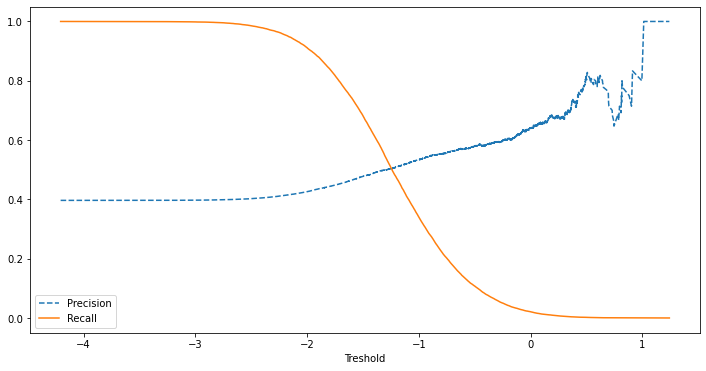

In [41]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=thresholds, y=precisions[:-1], ax=ax, label='Precision')
    sns.lineplot(x=thresholds, y=recalls[:-1], ax = ax, label='Recall')
    ax.lines[0].set_linestyle('--')
    ax.lines[1].set_linestyle('-')
    plt.xlabel('Treshold')
    plt.legend()
    plt.show()
    # plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    # plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

y_scores_sgd = \
    cross_val_predict(
        sgd_clf_model, X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), cv=3,
        method='decision_function')
precisions, recalls, thresholds = \
    precision_recall_curve(y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), y_scores_sgd)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

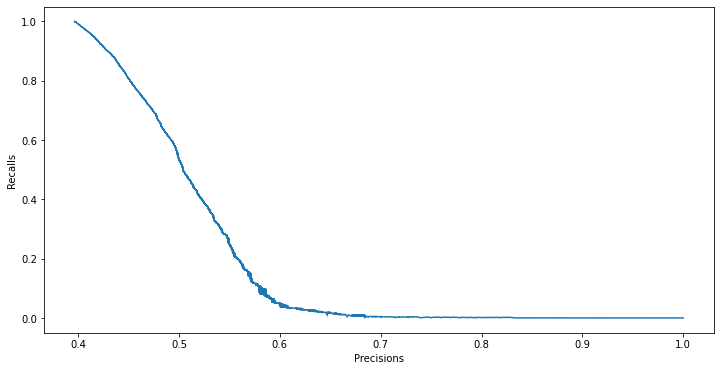

In [42]:
def plot_precision_recalls(precisions, recalls):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=precisions, y=recalls, ax=ax)
    plt.xlabel('Precisions')
    plt.ylabel('Recalls')
    
plot_precision_recalls(precisions, recalls)

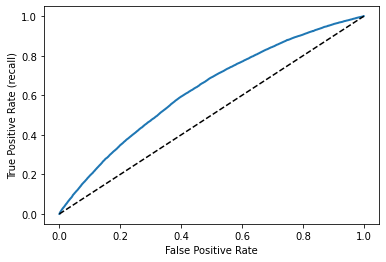

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), y_scores_sgd)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (recall)')

plot_roc_curve(fpr, tpr)
    

In [44]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), y_scores_sgd)

print(f'AUC Score= {auc:.2f}')

AUC Score= 0.63


In [45]:
from imblearn.metrics import classification_report_imbalanced

sgd_clf_model.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
y_pred_test = sgd_clf_model.predict(X_test_transf)

print(classification_report_imbalanced(y_test.map({'Fully Paid': 0, 'Charged Off': 1}), y_pred_test))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.81      0.44      0.83      0.60      0.37     36925
          1       0.34      0.44      0.81      0.39      0.60      0.34      8518

avg / total       0.76      0.74      0.51      0.75      0.60      0.36     45443



### 2.2. XGBoost Classifier

In [47]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(verbosity=0, use_label_encoder=False)
xgb_clf.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
y_pred_test = xgb_clf.predict(X_test_transf)

print(classification_report_imbalanced(y_test.map({'Fully Paid': 0, 'Charged Off': 1}), y_pred_test))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.81      0.43      0.83      0.59      0.36     36925
          1       0.34      0.43      0.81      0.38      0.59      0.33      8518

avg / total       0.76      0.74      0.50      0.75      0.59      0.35     45443



Optimal number of features: 25


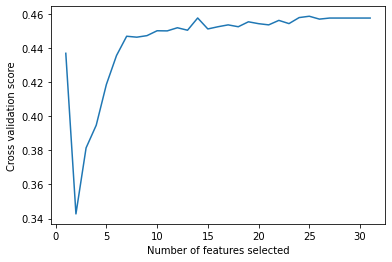

In [ ]:
features_evaluator = RFECV(estimator=xgb_clf, cv=StratifiedKFold(2), scoring='recall')
features_evaluator.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
rfecv_mean = features_evaluator.cv_results_['mean_test_score']
optimal_n_features = features_evaluator.n_features_

plot_feature_evaluator(rfecv_mean, optimal_n_features) 

In [ ]:
features_selector = RFECV(
    estimator=xgb_clf, cv=StratifiedKFold(2), scoring='recall',
    min_features_to_select=optimal_n_features)

xgb_clf_model = Pipeline([
    ('features_selector', features_selector),
    ('xgb_classifier', XGBClassifier(verbosity=0))
])

xgb_clf_model.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
y_pred_test = xgb_clf.predict(X_test_transf)

print(classification_report_imbalanced(y_test.map({'Fully Paid': 0, 'Charged Off': 1}), y_pred_test))